In [110]:
import requests
import urllib3
import json
import csv
import os
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [50]:
pd.set_option('display.max_columns', 83)
pd.set_option('display.max_colwidth', 25)
pd.set_option('display.max_rows', None)
pd.set_option("display.precision", 2)
sns.set(rc={'figure.figsize':(12.7,8.27)})

In [4]:
cd = os.path.abspath(os.getcwd())
with open(f'{cd}/config.json') as f:
    data = json.load(f)

In [ ]:
auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"
payload = data['payload']
res = requests.post(auth_url, data=payload, verify=False)
header = {'Authorization': 'Bearer ' + res.json()['access_token']}

my_activities = pd.DataFrame()
for page in range(1,99):
    my_dataset = requests.get(activites_url, headers=header, params={'per_page': 200, 'page': page}).json()
    my_dataframe = pd.json_normalize(my_dataset)
    my_activities = pd.concat([my_activities, my_dataframe], ignore_index=True)

In [ ]:
my_acts = my_activities.copy(deep=True)

In [ ]:
my_acts = my_acts.rename(columns={'average_speed' : 'average_speed_mps', 
                                        'max_speed' : 'max_speed_mps',
                                        'moving_time' : 'moving_time_s',
                                        'elapsed_time' : 'elapsed_time_s'})

# fix 'start_date_local' and create 2 new columns 'start_time' and 'moving_time(min)'
my_acts['start_date_local'] = pd.to_datetime(my_acts['start_date_local'])
my_acts['start_time'] = my_acts['start_date_local'].dt.time
my_acts['start_date_local'] = my_acts['start_date_local'].dt.strftime("%d/%m/%y")

# seconds to minutes
my_acts['moving_time(min)'] = my_acts['moving_time_s'].apply(lambda x: pd.to_datetime(x, unit='s').strftime('%H:%M:%S'))

# meters to kms
my_acts['distance'] = my_acts[
    (my_acts['type'] == 'Run') |
    (my_acts['type'] == 'Walk')]['distance'] / 1000

# meters per second to kms per hour
my_acts['average_speed_mps'] = my_acts['average_speed_mps'] * (18/5)
my_acts['max_speed_mps'] = my_acts['max_speed_mps'] * (18/5)

# from (GMT+01:00) Europe/Berlin -> Europe/Berlin
my_acts['timezone'] = my_acts['timezone'].str.split(' ').str[-1]

# rename converted columns
my_acts = my_acts.rename(columns={'average_speed_mps': 'average_speed_kmh',
                                        'max_speed_mps' : 'max_speed_kmh',
                                        'distance' : 'distance_km'})

In [ ]:
cols = ['upload_id', 'name', 'type', 'distance_km', 'moving_time(min)','start_time',  'start_date_local',  'timezone',
        'average_speed_kmh', 'max_speed_kmh', 'total_elevation_gain', 'average_heartrate',
        'max_heartrate', 'achievement_count', 'kudos_count', 'visibility',  ]
my_acts = my_acts[cols]

# usage -> 25.1 KB to 22.6 KB
my_acts['visibility'] = pd.Categorical(my_acts['visibility'])
my_acts['timezone'] = pd.Categorical(my_acts['timezone'])

In [ ]:
my_acts

In [ ]:
with open(f'{cd}/csvs/all_activities.csv', 'w') as activs_f:
    my_acts.to_csv(activs_f)

In [12]:
with open(f'{cd}/csvs/all_activities.csv', 'r') as activs_f:
    activities = pd.read_csv(activs_f, delimiter=',' , encoding='iso-8859-1', index_col=[0])

In [13]:
activities

,upload_id,name,type,distance_km,moving_time(min),start_time,start_date_local,timezone,average_speed_kmh,max_speed_kmh,total_elevation_gain,average_heartrate,max_heartrate,achievement_count,kudos_count,visibility
0,6569703249,Lunch Run,Run,9.11,00:54:25,11:03:22,29/10/21,Europe/Berlin,10.05,24.90,11.3,155.1,171.0,0,2,everyone
1,6569703133,Morning Activity,Workout,NaN,00:36:02,08:01:53,29/10/21,Europe/Berlin,0.00,0.00,0.0,68.4,89.0,0,0,only_me
2,6567619763,Evening Walk,Walk,1.10,00:11:06,19:58:51,28/10/21,Europe/Berlin,5.92,10.48,0.0,106.0,112.0,0,0,only_me
3,6567619739,Evening Walk,Walk,1.04,00:10:45,19:27:50,28/10/21,Europe/Berlin,5.80,17.69,0.0,117.9,169.0,0,0,only_me
4,6567619727,Afternoon Walk,Walk,2.77,00:27:28,17:54:54,28/10/21,Europe/Berlin,6.06,26.81,6.3,109.6,122.0,0,0,only_me
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,1794841463,не е зле,Run,3.91,00:22:51,12:03:25,30/06/18,Europe/Berlin,10.27,19.08,29.8,NaN,NaN,6,0,everyone
1084,1789156768,Afternoon Run,Run,3.81,00:23:52,17:45:10,27/06/18,Europe/Berlin,9.57,15.48,27.3,NaN,NaN,1,0,everyone
1085,1781438284,not bad,Run,3.08,00:18:20,10:29:42,24/06/18,Europe/Berlin,10.09,16.92,23.3,NaN,NaN,4,0,everyone
1086,1775112184,1 time Vibram,Run,3.09,00:17:44,17:07:55,20/06/18,Europe/Berlin,10.47,21.24,18.5,NaN,NaN,4,0,everyone


 IDEAS
 check the name: 'run'-> move to a new df['running']
                'other' -> df['rest_sessions']
activities

Text(0.5, 1.0, "Each activity's # of occurences")

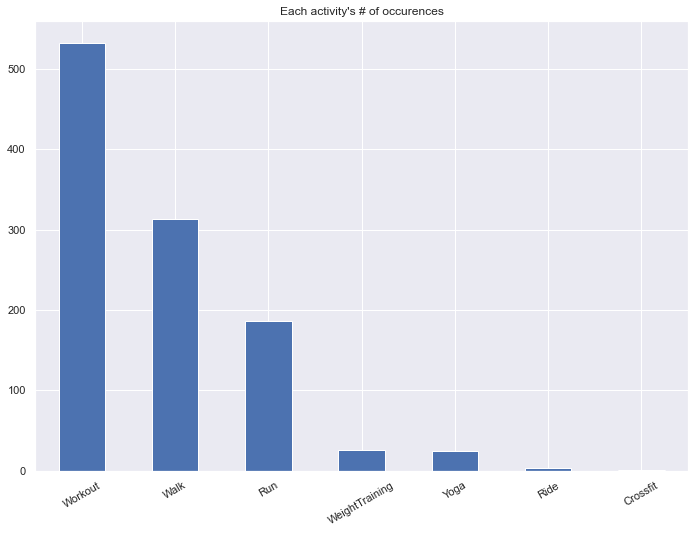

In [42]:
activities['type'].value_counts().plot(kind='bar', rot=30).set_title("Each activity's # of occurences")

<AxesSubplot:xlabel='type', ylabel='count'>

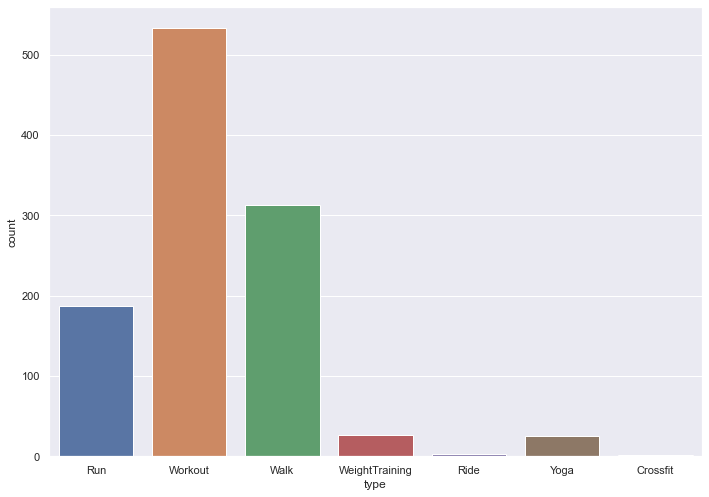

In [40]:
sns.countplot(x='type',
              data=activities)

In [34]:
run = activities.loc[activities['type'] == 'Run']

In [48]:
run.shape

,upload_id,name,type,distance_km,moving_time(min),start_time,start_date_local,timezone,average_speed_kmh,max_speed_kmh,total_elevation_gain,average_heartrate,max_heartrate,achievement_count,kudos_count,visibility
0,6569703249,Lunch Run,Run,9.11,00:54:25,11:03:22,29/10/21,Europe/Berlin,10.05,24.90,11.3,155.1,171.0,0,2,everyone
10,6556786134,Afternoon Run,Run,13.04,01:23:51,17:27:55,26/10/21,Europe/Berlin,9.33,20.28,28.4,160.8,176.0,1,6,everyone
19,6545829298,Afternoon Run,Run,6.65,00:41:54,13:52:33,24/10/21,Europe/Berlin,9.53,19.85,5.3,164.8,183.0,0,4,everyone
26,6535717805,Afternoon Run,Run,11.01,01:07:17,15:25:48,22/10/21,Europe/Berlin,9.82,20.88,33.3,159.0,168.0,3,5,everyone
36,6520128557,Lunch Run,Run,12.08,01:12:09,11:04:06,19/10/21,Europe/Berlin,10.05,16.56,22.4,148.7,167.0,2,5,everyone
46,6504249593,Lunch Run,Run,16.15,01:39:33,11:41:22,16/10/21,Europe/Berlin,9.73,17.28,61.6,150.0,168.0,1,7,everyone
52,6495456439,Afternoon Run,Run,3.13,00:15:37,16:52:48,14/10/21,Europe/Berlin,12.03,18.72,0.0,169.7,178.0,1,6,everyone
61,6483777592,Lunch Run,Run,7.13,00:41:20,11:17:10,12/10/21,Europe/Berlin,10.35,20.52,9.6,156.4,181.0,0,7,everyone
73,6472827221,Morning Run,Run,9.13,00:55:16,09:57:30,10/10/21,Europe/Berlin,9.91,19.08,18.5,158.9,172.0,0,5,everyone
82,6462476583,Morning Run,Run,10.06,01:00:38,10:35:19,08/10/21,Europe/Berlin,9.95,22.68,20.6,158.9,183.0,2,7,everyone


Text(0, 0.5, 'Count')

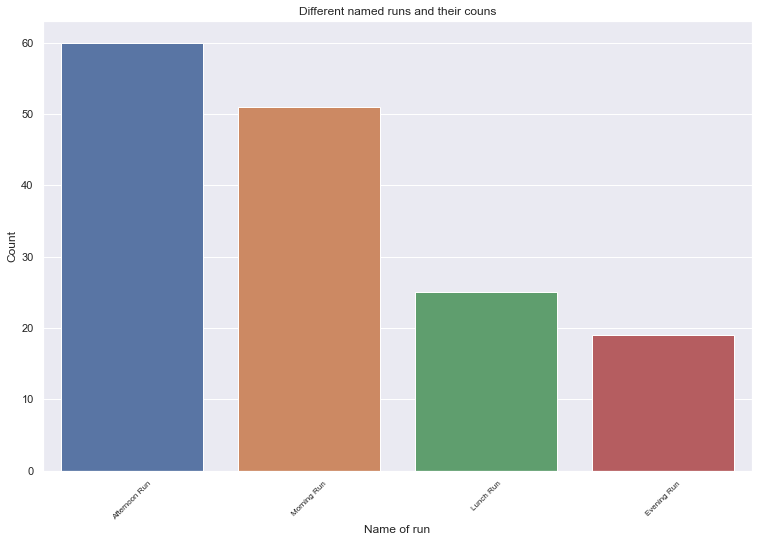

In [65]:
sns.countplot(x='name', 
              data=run, 
              order=pd.value_counts(run['name']).iloc[:4].index)
locs, labels = plt.xticks(rotation=45, fontsize=8)
plt.title("Different named runs and their couns")
plt.xlabel("Name of run")
plt.ylabel("Count")

In [77]:
run_5_more = run[run['distance_km'] > 5]

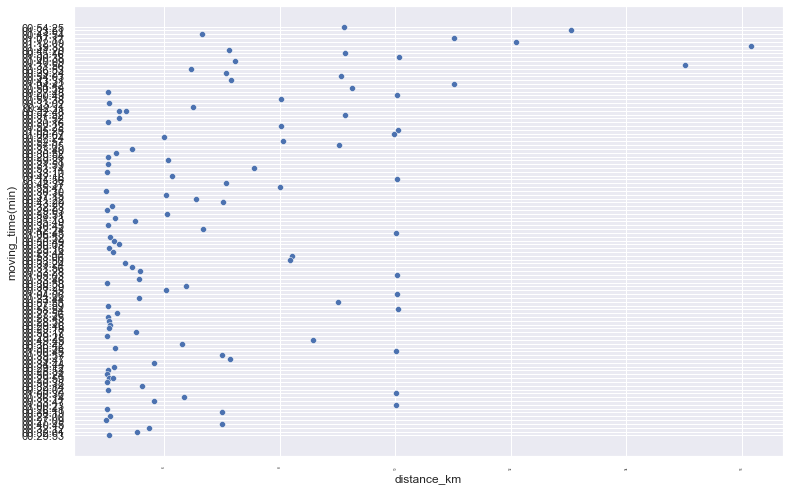

In [81]:
sns.scatterplot(x='distance_km',
                y='moving_time(min)',
                data=run_5_more)
locs,label = plt.xticks(rotation=90, fontsize=3)

Text(0.5, 1.0, 'Average Speed vs Distance')

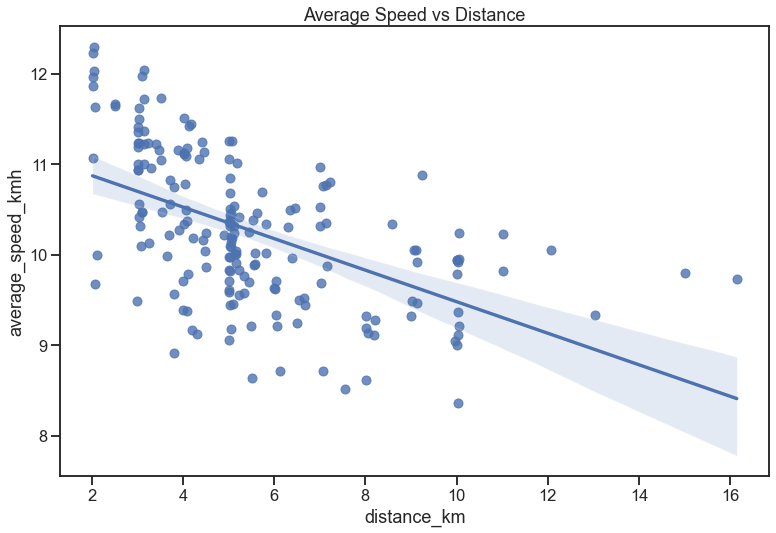

In [85]:
sns.set(style="ticks", context="talk")
sns.regplot(x="distance_km", y="average_speed_kmh", data=run).set_title("Average Speed vs Distance")

Text(0.5, 1.0, 'Max Speed vs Distance')

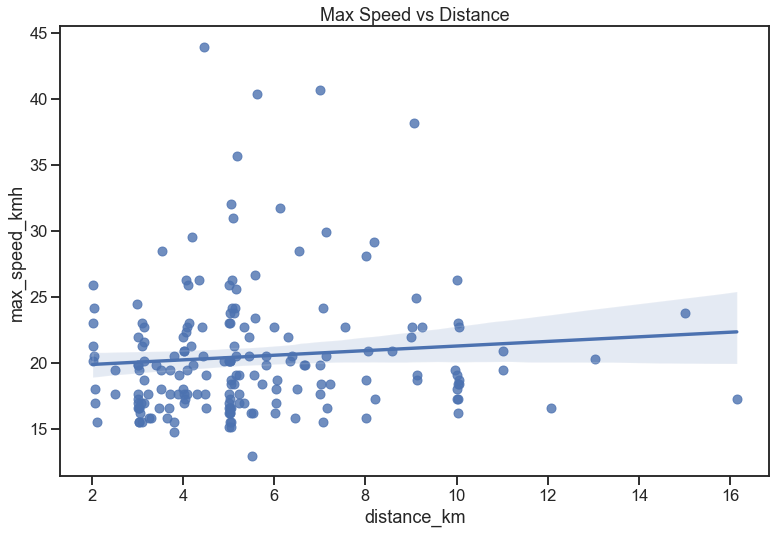

In [86]:
sns.set(style="ticks", context="talk")
sns.regplot(x='distance_km', y='max_speed_kmh', data=run).set_title("Max Speed vs Distance")

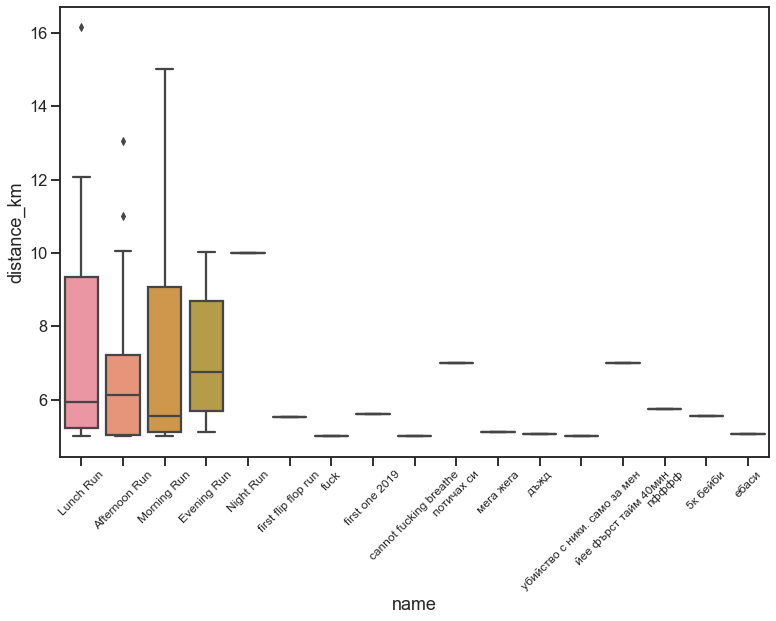

In [105]:
sns.boxplot(x='name',y='distance_km',data=run_5_more)
locs, labels = plt.xticks(rotation=45, fontsize=12)

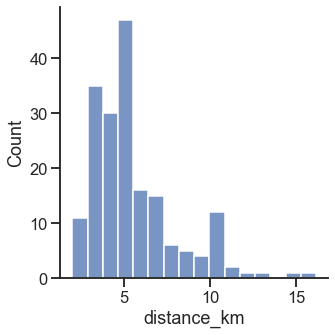

In [109]:
sns.displot(run['distance_km'])